In [1]:
import os
import shutil
import sys
import time
from PIL import Image
from datetime import date, datetime, timedelta


sys.path.insert(0, '..')
from utils import mongodb

In [2]:
from pesagensbalanca import cursor_pesagensbalanca, extract_to

# Gera base de dados de pesagens
Necessário acesso ao Banco de Dados ou ao Servidor

In [3]:
start = datetime(2020, 3, 1)
end = datetime.today()
limit = 10
s0 = time.time()
# cursor = cursor_pesagensbalanca(mongodb, start, end, limit, crop=True)
# count = extract_to(cursor, crop=True)
s1 = time.time()
# print('{:0.2f} segundos para processar {:d} registros'.format((s1 - s0), count))


# Carregar e montar modelo

In [4]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau



In [5]:
regression_model = models.Sequential([
  layers.Conv2D(16, (7, 7), activation='relu',
                padding='same',
                strides=(2, 2),
                input_shape=(144, 288, 3)),
  layers.MaxPooling2D(pool_size=(2, 4)),
  layers.Dropout(0.25),
  layers.Conv2D(16, (5, 5), 
                strides=(2, 2),
                activation='relu', padding='same'),
  layers.Dropout(0.25),
  layers.Conv2D(16, (5, 5), 
                strides=(2, 2),
                activation='relu'),
  layers.Dropout(0.25),
  layers.AvgPool2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(1)
 
])
regression_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 72, 144, 16)       2368      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 16)        6416      
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          6416      
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 16)          0

In [17]:
# regression_model.load_weights('gerabasespesagens_cropped2.hdf5')

In [18]:
for layer in regression_model.layers:
    print(layer, layer.trainable)


<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8b84319f60> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8b8431c438> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f8b8431c5f8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8b8431c710> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f8b8431cb70> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8b8431cc88> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f8b8431d128> True
<tensorflow.python.keras.layers.pooling.AveragePooling2D object at 0x7f8b8431d240> True
<tensorflow.python.keras.layers.core.Flatten object at 0x7f8b8431d438> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f8b8431d550> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f8b8431d860> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f8b8431db70> True
<tensorflow.python.keras.layers.core.Dense objec

# Carregar e montar dados para treinamento

In [9]:
df = pd.read_pickle('df_final_filtered_pesagensbalanca.pkl')
df.head()

,id,pesobalanca,pesodeclarado,dif,filename,preds,dif_pred
1,5e5d09703d0ec8337863f9ee,29190,29149,41,5e5d09703d0ec8337863f9ee.jpg,23781.847656,5408.152344
3,5e5d099986556b3036c6dc6d,7610,7788,178,5e5d099986556b3036c6dc6d.jpg,7073.970215,536.029785
4,5e5d094386556b3036c6dc5c,22280,22300,20,5e5d094386556b3036c6dc5c.jpg,23390.078125,1110.078125
8,5e5d094386556b3036c6dc60,8420,8448,28,5e5d094386556b3036c6dc60.jpg,7730.686035,689.313965
10,5e5d09703d0ec8337863f9fa,9160,9516,356,5e5d09703d0ec8337863f9fa.jpg,10732.575195,1572.575195


In [10]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df.pesobalanca.values.reshape(-1, 1))


/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
df['pesoscaled'] = scaled

In [12]:
df.describe()

,pesobalanca,pesodeclarado,dif,preds,dif_pred,pesoscaled
count,6652.000000,6652.000000,6652.000000,6652.000000,6652.000000,6.652000e+03
mean,18204.968581,18241.627330,214.162357,17884.900391,2167.843764,-1.068164e-16
std,7559.530088,7543.995047,205.533548,6904.848633,1561.269670,1.000075e+00
min,2370.000000,2211.000000,0.000000,4207.561523,0.507812,-2.094860e+00
25%,11240.000000,11305.750000,62.000000,10990.872559,831.310791,-9.214187e-01
50%,19695.000000,19790.000000,143.000000,19717.713867,1885.833008,1.971212e-01
75%,24160.000000,24160.000000,306.000000,24023.826660,3269.851196,7.878108e-01
max,29980.000000,30291.000000,999.000000,29644.216797,5998.706055,1.557758e+00


In [13]:
splitmask = np.random.rand(len(df)) < 0.8
df_train = df[splitmask]
df_val = df[~splitmask]

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='../../bases/pesagensbalanca/pesagensbalanca_cropped',
    target_size=(144, 288),
    batch_size=256,
    x_col='filename',
    y_col="pesoscaled",
    shuffle=False,
    class_mode='raw',
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory='../../bases/pesagensbalanca/pesagensbalanca_cropped',
    target_size=(144, 288),
    batch_size=128,
    x_col='filename',
    y_col="pesoscaled",
    shuffle=False,
    class_mode='raw',
)

Found 5308 validated image filenames.
Found 1344 validated image filenames.


In [35]:
def get_learning_rate(num_batch, num_batches, lr):
    new_lr = lr / (num_batches - num_batch)
    print(new_lr, num_batch, num_batches)
    return new_lr

regression_model.compile(optimizer=optimizers.SGD(lr=0.0001),
                         loss='mean_absolute_error', metrics=['mse', 'mae', 'msle'])

for ind in range(41):
    X, y = next(train_generator)
    lr = 0.0001 * ind / 40
    regression_model.optimizer.lr = lr
    loss = regression_model.train_on_batch(X, y)
    print(ind, lr, loss[0])



0 0.0 0.9531647
1 2.5e-06 0.95482135
2 5e-06 0.9652383
3 7.500000000000001e-06 0.8636926
4 1e-05 0.7581468
5 1.25e-05 0.8452565
6 1.5000000000000002e-05 0.85642695
7 1.75e-05 0.8120496
8 2e-05 0.8335457
9 2.25e-05 0.9590044
10 2.5e-05 0.8069035
11 2.75e-05 0.8369831
12 3.0000000000000004e-05 0.8682989
13 3.2500000000000004e-05 0.78822047
14 3.5e-05 0.89375705
15 3.7500000000000003e-05 0.9335689
16 4e-05 1.0370041
17 4.25e-05 0.8151682
18 4.5e-05 0.80402714
19 4.75e-05 0.9121613
20 5e-05 0.759274
21 5.250000000000001e-05 0.9485689
22 5.5e-05 0.95359325
23 5.75e-05 0.96620935
24 6.000000000000001e-05 0.8613446
25 6.25e-05 0.7631954
26 6.500000000000001e-05 0.8446597
27 6.75e-05 0.8565626
28 7e-05 0.8083486
29 7.25e-05 0.83384037
30 7.500000000000001e-05 0.95957637
31 7.750000000000001e-05 0.80468154
32 8e-05 0.8370583
33 8.25e-05 0.86680394
34 8.5e-05 0.7935507
35 8.75e-05 0.8945095
36 9e-05 0.93524504
37 9.25e-05 1.0382667
38 9.5e-05 0.8140478
39 9.750000000000001e-05 0.80217797
40 0.00

# Treinar modelo

In [36]:
regression_model.compile(optimizer=optimizers.Adam(lr=0.001),
                         loss='mean_absolute_error', metrics=['mse', 'mae', 'msle'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,
                          verbose=1, mode='min')

In [37]:
regression_model.fit(train_generator, epochs=30, shuffle=False,
                     callbacks=[reduce_lr],
                     validation_data = val_generator,
                     validation_steps = val_generator.samples // 128)

Train for 21 steps, validate for 10 steps
Epoch 1/20
21/21 [==============================] - 57s 3s/step - loss: 0.5842 - mse: 0.5494 - mae: 0.5855 - msle: 0.0856 - val_loss: 0.4285 - val_mse: 0.3058 - val_mae: 0.4285 - val_msle: 0.0618
Epoch 2/20
21/21 [==============================] - 57s 3s/step - loss: 0.4217 - mse: 0.2862 - mae: 0.4215 - msle: 0.0494 - val_loss: 0.3802 - val_mse: 0.2242 - val_mae: 0.3802 - val_msle: 0.0437
Epoch 3/20
21/21 [==============================] - 56s 3s/step - loss: 0.3989 - mse: 0.2517 - mae: 0.3988 - msle: 0.0424 - val_loss: 0.3742 - val_mse: 0.2145 - val_mae: 0.3742 - val_msle: 0.0378
Epoch 4/20
21/21 [==============================] - 56s 3s/step - loss: 0.3822 - mse: 0.2292 - mae: 0.3821 - msle: 0.0397 - val_loss: 0.3672 - val_mse: 0.2048 - val_mae: 0.3672 - val_msle: 0.0417
Epoch 5/20
21/21 [==============================] - 55s 3s/step - loss: 0.3691 - mse: 0.2145 - mae: 0.3688 - msle: 0.0381 - val_loss: 0.3707 - val_mse: 0.2112 - val_mae: 0.37

In [38]:
regression_model.save_weights('gerabasespesagens_cropped2_basefiltrada_scaled_warmup.hdf5')

In [39]:
regression_model.compile(optimizer=optimizers.Adam(lr=0.0006),
                         loss='mean_absolute_error', metrics=['mse', 'mae', 'msle'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                          verbose=1, mode='min')

In [40]:
regression_model.fit(train_generator, epochs=30,
                     callbacks=[reduce_lr],
                     validation_data = val_generator,
                     validation_steps = val_generator.samples // 128)

Train for 21 steps, validate for 10 steps
Epoch 1/20
21/21 [==============================] - 70s 3s/step - loss: 0.2991 - mse: 0.1434 - mae: 0.2993 - msle: 0.0276 - val_loss: 0.2682 - val_mse: 0.1232 - val_mae: 0.2682 - val_msle: 0.0254
Epoch 2/20
21/21 [==============================] - 60s 3s/step - loss: 0.2838 - mse: 0.1323 - mae: 0.2840 - msle: 0.0254 - val_loss: 0.2733 - val_mse: 0.1245 - val_mae: 0.2733 - val_msle: 0.0251
Epoch 3/20
21/21 [==============================] - 61s 3s/step - loss: 0.2795 - mse: 0.1291 - mae: 0.2797 - msle: 0.0245 - val_loss: 0.2624 - val_mse: 0.1189 - val_mae: 0.2624 - val_msle: 0.0247
Epoch 4/20
21/21 [==============================] - 58s 3s/step - loss: 0.2830 - mse: 0.1312 - mae: 0.2831 - msle: 0.0252 - val_loss: 0.2767 - val_mse: 0.1248 - val_mae: 0.2767 - val_msle: 0.0256
Epoch 5/20
20/21 [===========================>..] - ETA: 2s - loss: 0.2789 - mse: 0.1280 - mae: 0.2789 - msle: 0.0243
Epoch 00005: ReduceLROnPlateau reducing learning rate to

In [41]:
regression_model.compile(optimizer=optimizers.Adam(lr=0.0003),
                         loss='mean_absolute_error', metrics=['mse', 'mae', 'msle'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=2,
                          verbose=1, mode='min')

In [42]:
regression_model.fit(train_generator, epochs=30,
                     callbacks=[reduce_lr],
                     validation_data = val_generator,
                     validation_steps = val_generator.samples // 128)

Train for 21 steps, validate for 10 steps
Epoch 1/30
21/21 [==============================] - 59s 3s/step - loss: 0.2645 - mse: 0.1178 - mae: 0.2647 - msle: 0.0233 - val_loss: 0.2474 - val_mse: 0.1091 - val_mae: 0.2474 - val_msle: 0.0238
Epoch 2/30
21/21 [==============================] - 58s 3s/step - loss: 0.2624 - mse: 0.1174 - mae: 0.2626 - msle: 0.0226 - val_loss: 0.2496 - val_mse: 0.1106 - val_mae: 0.2496 - val_msle: 0.0248
Epoch 3/30
20/21 [===========================>..] - ETA: 2s - loss: 0.2635 - mse: 0.1150 - mae: 0.2634 - msle: 0.0225
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
21/21 [==============================] - 59s 3s/step - loss: 0.2636 - mse: 0.1153 - mae: 0.2636 - msle: 0.0222 - val_loss: 0.2531 - val_mse: 0.1128 - val_mae: 0.2531 - val_msle: 0.0241
Epoch 4/30
21/21 [==============================] - 57s 3s/step - loss: 0.2614 - mse: 0.1145 - mae: 0.2614 - msle: 0.0221 - val_loss: 0.2491 - val_mse: 0.1104 - val_mae: 0.2491 - val

In [43]:
# regression_model.save_weights('gerabasespesagens_cropped2_basefiltrada_scaled_warmup_tunned.hdf5')

In [6]:
regression_model.load_weights('gerabasespesagens_cropped2_basefiltrada_scaled_warmup_tunned.hdf5')

## Fine tunning

In [25]:
for layer in regression_model.layers:
    layer.trainable = True
for layer in regression_model.layers[:-4]:
    layer.trainable = False
for layer in regression_model.layers:
    print(layer, layer.trainable)


<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9329d44d68> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9329ccf390> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329ccf588> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9329ccf6d8> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329ccfb38> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9329ccfc50> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329cdf0f0> False
<tensorflow.python.keras.layers.pooling.AveragePooling2D object at 0x7f9329cdf208> False
<tensorflow.python.keras.layers.core.Flatten object at 0x7f9329cdf400> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f9329cdf550> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9329cdf860> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329cdfb70> True
<tensorflow.python.keras.layers.core.De

In [30]:
regression_model.compile(optimizer=optimizers.SGD(lr=0.001),
                         loss='mean_squared_logarithmic_error', metrics=['msle', 'mae', 'mse'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                          verbose=1, mode='min')

In [28]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='../../bases/pesagensbalanca/pesagensbalanca_cropped',
    target_size=(144, 288),
    batch_size=128,
    x_col='filename',
    y_col="pesobalanca",
    shuffle=False,
    class_mode='raw',
)


Found 7283 validated image filenames.


In [31]:
regression_model.fit(train_generator, epochs=20, shuffle=False,
                     callbacks=[reduce_lr],
                     validation_data = val_generator,
                     validation_steps = val_generator.samples // 64)

Train for 57 steps, validate for 12 steps
Epoch 1/20
57/57 [==============================] - 71s 1s/step - loss: 0.0947 - msle: 0.0947 - mae: 3608.4629 - mse: 23316486.0000 - val_loss: 0.1091 - val_msle: 0.1091 - val_mae: 3562.4495 - val_mse: 23320314.0000
Epoch 2/20
57/57 [==============================] - 71s 1s/step - loss: 0.0960 - msle: 0.0960 - mae: 3634.3882 - mse: 23902398.0000 - val_loss: 0.1093 - val_msle: 0.1093 - val_mae: 3560.1953 - val_mse: 23409062.0000
Epoch 3/20
57/57 [==============================] - 69s 1s/step - loss: 0.0959 - msle: 0.0959 - mae: 3642.7004 - mse: 23762100.0000 - val_loss: 0.1079 - val_msle: 0.1079 - val_mae: 3559.0322 - val_mse: 23223136.0000
Epoch 4/20
57/57 [==============================] - 68s 1s/step - loss: 0.0953 - msle: 0.0953 - mae: 3632.0486 - mse: 23893478.0000 - val_loss: 0.1082 - val_msle: 0.1082 - val_mae: 3570.1289 - val_mse: 23299914.0000
Epoch 5/20
57/57 [==============================] - 88s 2s/step - loss: 0.0955 - msle: 0.0955 

In [67]:
regression_model.compile(optimizer=optimizers.SGD(lr=0.0001),
                         loss='mean_absolute_error', metrics=['msle', 'mae', 'mse'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                          verbose=1, mode='min')

In [68]:
regression_model.fit(train_generator, epochs=20, shuffle=False,
                     callbacks=[reduce_lr],
                     validation_data = val_generator,
                     validation_steps = val_generator.samples // 64)

Train for 57 steps, validate for 12 steps
Epoch 1/20
57/57 [==============================] - 68s 1s/step - loss: 5622.2075 - msle: 0.1992 - mae: 5624.1997 - mse: 55791784.0000 - val_loss: 3756.6118 - val_msle: 0.1211 - val_mae: 3756.6116 - val_mse: 26991670.0000
Epoch 2/20
57/57 [==============================] - 69s 1s/step - loss: 4039.2813 - msle: 0.1083 - mae: 4039.6230 - mse: 28704642.0000 - val_loss: 3569.9286 - val_msle: 0.1115 - val_mae: 3569.9285 - val_mse: 23872918.0000
Epoch 3/20
57/57 [==============================] - 68s 1s/step - loss: 3988.0034 - msle: 0.1053 - mae: 3987.5867 - mse: 27424336.0000 - val_loss: 3688.5720 - val_msle: 0.1213 - val_mae: 3688.5723 - val_mse: 26035480.0000
Epoch 4/20
57/57 [==============================] - 67s 1s/step - loss: 3891.8890 - msle: 0.1026 - mae: 3891.7432 - mse: 26609566.0000 - val_loss: 3542.2460 - val_msle: 0.1098 - val_mae: 3542.2463 - val_mse: 23128936.0000
Epoch 5/20
57/57 [==============================] - 67s 1s/step - loss

In [110]:
regression_model.save_weights('gerabasespesagens_cropped2_finetunning.h5')

# Avaliação

In [38]:
mean = scaler.mean_
scale = scaler.scale_
print(mean, scale)

[18204.96858088] [7558.96185212]


[18547.469] 19350


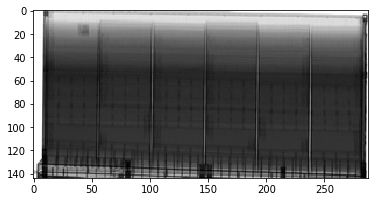

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
sample = df.sample()
filename = sample['filename'].item()
image = Image.open('../../bases/pesagensbalanca/pesagensbalanca_cropped/' + filename)
image = image.resize((288, 144), Image.LANCZOS)
image_array = np.expand_dims(np.array(image), axis=0) / 255
pred = regression_model.predict(image_array)[0][0]
pred_scaled = scaler.inverse_transform([pred])
print(pred_scaled, sample['pesobalanca'].item())
plt.imshow(image)

In [42]:
pred * scale + mean

array([18547.4690703])

In [16]:
y_preds_train = regression_model.predict_generator(train_generator)

In [17]:
y_preds_val = regression_model.predict_generator(val_generator)

In [18]:
df_val.shape

(1344, 8)

In [19]:
y_preds_val.shape

(1344, 1)

In [20]:
df_val['preds'] = scaler.inverse_transform(y_preds_val)

/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
df_val.head()

,id,pesobalanca,pesodeclarado,dif,filename,preds,dif_pred,pesoscaled
21,5e5d096a3d0ec8337863f791,21770,21700,70,5e5d096a3d0ec8337863f791.jpg,22792.464844,2710.771484,0.471630
29,5e5d096a3d0ec8337863f79d,22120,22148,28,5e5d096a3d0ec8337863f79d.jpg,21466.755859,2698.906250,0.517932
38,5e5d096a3d0ec8337863f7a9,26960,26776,184,5e5d096a3d0ec8337863f7a9.jpg,24661.103516,4361.814453,1.158232
44,5e5d096b3d0ec8337863f7b5,22750,22354,396,5e5d096b3d0ec8337863f7b5.jpg,22041.738281,715.941406,0.601277
50,5e5d096a3d0ec8337863f771,23460,23445,15,5e5d096a3d0ec8337863f771.jpg,22602.923828,18.792969,0.695205


In [22]:
df_val['dif_pred'] = abs(df_val['pesobalanca'] - df_val['preds'])

/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
df_val.describe()

,pesobalanca,pesodeclarado,dif,preds,dif_pred,pesoscaled
count,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000
mean,18327.865327,18367.426339,222.071429,18299.316406,1727.174556,0.016258
std,7530.509492,7513.439805,212.120340,6997.949219,1487.007330,0.996236
min,2430.000000,2481.000000,0.000000,1509.804565,1.898438,-2.086923
25%,11310.000000,11464.750000,64.000000,11004.139893,587.117432,-0.912158
50%,19710.000000,19817.500000,150.000000,20591.000977,1307.716797,0.199106
75%,24212.500000,24224.500000,308.250000,24042.435547,2479.537109,0.794756
max,29950.000000,30144.000000,999.000000,29956.519531,12332.507812,1.553789


In [24]:
np.bincount(pd.np.digitize(df_val['dif_pred'], bins = [1000, 2000, 3000, 4000]))

array([536, 349, 215, 128, 116])

In [25]:
sum(df_val.dif_pred > 4000)

116

In [26]:
df_train['preds'] = scaler.inverse_transform(y_preds_train)

/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
df_train['dif_pred'] = abs(df_train['pesobalanca'] - df_train['preds'])

/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
df_train.describe()

,pesobalanca,pesodeclarado,dif,preds,dif_pred,pesoscaled
count,5308.000000,5308.000000,5308.000000,5308.000000,5308.000000,5308.000000
mean,18173.850791,18209.774680,212.159759,18161.566406,1729.720702,-0.004117
std,7567.251231,7552.085294,203.803761,7018.432129,1543.738114,1.001097
min,2370.000000,2211.000000,0.000000,1602.654175,0.156250,-2.094860
25%,11205.000000,11250.500000,62.000000,10928.436523,549.743652,-0.926049
50%,19690.000000,19777.000000,140.000000,20324.028320,1267.336914,0.196460
75%,24142.500000,24147.000000,305.000000,23905.467773,2510.841064,0.785496
max,29980.000000,30291.000000,999.000000,30765.099609,12978.962891,1.557758


In [29]:
np.bincount(pd.np.digitize(df_train['dif_pred'], bins = [1000, 2000, 3000, 4000]))

array([2223, 1298,  793,  486,  508])

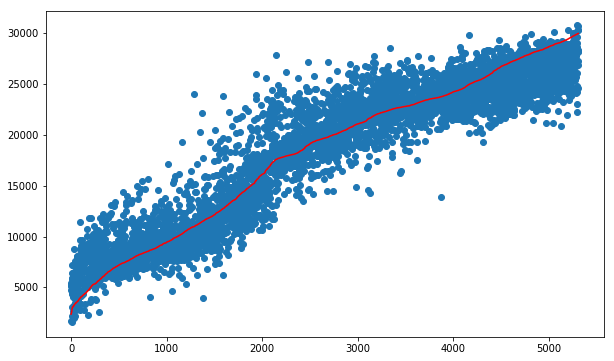

In [30]:
plt.figure(figsize=(10,6))
df_sorted = df_train.sort_values(by='pesobalanca')
x = range(len(df_sorted))
plt.scatter(x=x, y=list(df_sorted.preds))
plt.plot(list(df_sorted.pesobalanca), color='r')


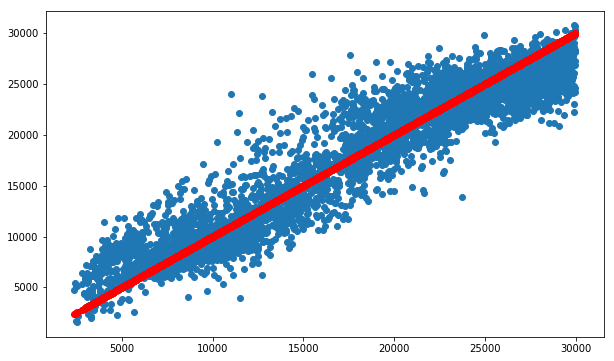

In [31]:
plt.figure(figsize=(10,6))
plt.scatter(x=list(df_sorted.pesobalanca), y=list(df_sorted.preds))
plt.scatter(x=list(df_sorted.pesobalanca), y=list(df_sorted.pesobalanca), color='r')

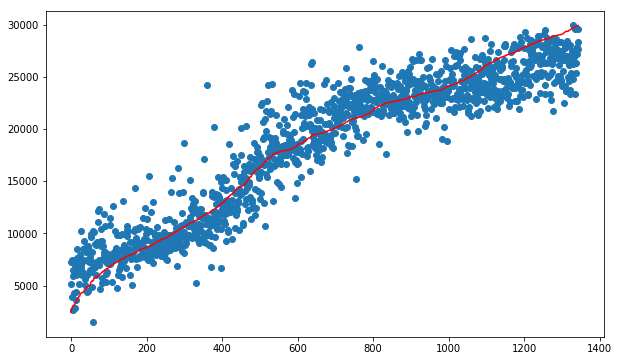

In [32]:
plt.figure(figsize=(10,6))
df_sorted = df_val.sort_values(by='pesobalanca')
x = range(len(df_sorted))
plt.scatter(x=x, y=list(df_sorted.preds))
plt.plot(list(df_sorted.pesobalanca), color='r')

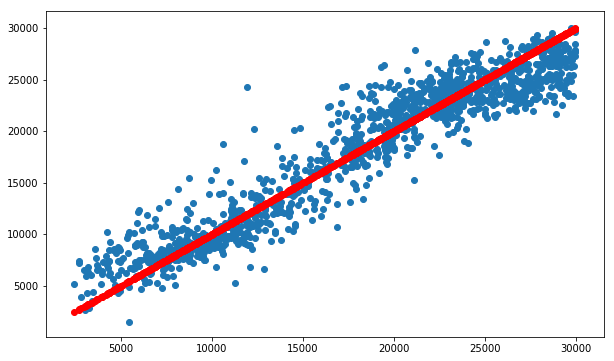

In [33]:
plt.figure(figsize=(10,6))
plt.scatter(x=list(df_sorted.pesobalanca), y=list(df_sorted.preds))
plt.scatter(x=list(df_sorted.pesobalanca), y=list(df_sorted.pesobalanca), color='r')

# Exportar para tensorflow serving

In [36]:
# Os valores abaixo precisam ser guardados e a predição colocada na escala correta com:
# pred * scale + mean
print(scaler.mean_, scaler.scale_)

[18204.96858088] [7558.96185212]


In [34]:
from tensorflow.keras import layers
from tensorflow.keras import models

regression_model = models.Sequential([
  layers.Conv2D(16, (7, 7), activation='relu',
                padding='same',
                strides=(2, 2),
                input_shape=(144, 288, 3)),
  layers.MaxPooling2D(pool_size=(2, 4)),
  layers.Dropout(0.25),
  layers.Conv2D(16, (5, 5), 
                strides=(2, 2),
                activation='relu', padding='same'),
  layers.Dropout(0.25),
  layers.Conv2D(16, (5, 5), 
                strides=(2, 2),
                activation='relu'),
  layers.Dropout(0.25),
  layers.AvgPool2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(1)
 
])
regression_model.load_weights('gerabasespesagens_cropped2_basefiltrada_scaled_warmup_tunned.hdf5')

In [47]:
import tensorflow as tf


MODEL_DIR = './tfserving'
version = 1
export_path = os.path.join(MODEL_DIR, 'peso', str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    regression_model,
    export_path,
    overwrite=True,
    include_optimizer=False,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = ./tfserving/peso/1


Saved model:
total 192
drwxr-xr-x 2 ivan ivan   4096 Abr  6 10:08 assets
-rw-rw-r-- 1 ivan ivan 185367 Abr  6 10:08 saved_model.pb
drwxr-xr-x 2 ivan ivan   4096 Abr  6 10:08 variables


In [20]:
# Executar na linha de comando:
# tensorflow_model_server   --rest_api_port=8501  --model_name='peso'  --model_base_path="tfserving/peso/1"
import numpy as np
import os
import requests
from PIL import Image

IMAGE_PATH = '../../bases/pesagensbalanca/pesagensbalanca_cropped/'

def prepare_images(filenames):
    images = list()
    for filename in filenames:
        image = Image.open(os.path.join(IMAGE_PATH, filename))
        image = image.resize((288, 144), Image.LANCZOS)
        image_array = np.array(image) / 255
        images.append(image_array.tolist())
    return images

        
def rescale(pred):
    peso = pred * 7558.96 + 18204.96
    return peso

images = prepare_images(os.listdir(IMAGE_PATH)[:16])

In [29]:

json_batch = {"signature_name": "serving_default", "instances": images}
r = requests.post('http://localhost:8501/v1/models/peso:predict', json=json_batch)
print(r.text)

{
    "predictions": [[-0.0945815518], [1.31291544], [-0.892532349], [0.566698611], [0.791771054], [-0.356804579], [-1.11517954], [0.648615181], [-1.4110328], [-0.415910274], [-1.18397748], [0.289904267], [1.09787583], [0.625535965], [0.0675639287], [0.5964185]
    ]
}


In [30]:
predictions = r.json()['predictions']
print([rescale(pred[0]) for pred in predictions])

[17490.021833205872, 28129.235294342398, 11458.34367520296, 22488.612132604558, 24189.92572634384, 15507.888459522159, 9775.362464321599, 23107.81620857176, 7539.0195061119975, 15061.110875244958, 9255.321587779199, 20396.334758082317, 26503.7594839368, 22933.3613379964, 18715.67303448615, 22713.26358476]


In [ ]:
# To serve multiple models, create a file like:
#tfserving/model_config.config

model_config_list: {
  config: {
    name: "peso" ,
    base_path: "/home/ivan/pybr/projeto/extracoes/notebooks/tfserving/peso" ,
    model_platform: " tensorflow" 
  },
  config: {
    name: "vazio",
    base_path: "/home/ivan/pybr/projeto/extracoes/notebooks/tfserving/vazio",
    model_platform: "tensorflow" 
  }
}